In [4]:
import pandas as pd
import os

# 1. Define the path to your 'raw' folder inside 'data'
# '..' goes up from 'notebooks', then into 'data', then into 'raw'
raw_data_path = os.path.join('..', 'data', 'raw')

# 2. Use your exact filenames
ecommerce_path = os.path.join(raw_data_path, 'Fraud_Data.csv')
bank_path = os.path.join(raw_data_path, 'creditcard.csv')
ip_path = os.path.join(raw_data_path, 'IpAddress_to_Country.csv')

# 3. Load the files
try:
    df_ecommerce = pd.read_csv(ecommerce_path)
    df_bank = pd.read_csv(bank_path)
    # df_ip = pd.read_csv(ip_path) # Only load this if you need it for merging
    print("✅ Success! Files found in data/raw and loaded.")
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Make sure your folders are named exactly 'data' and 'raw' (lowercase).")

# We will start by modeling the E-commerce data
df = df_ecommerce

✅ Success! Files found in data/raw and loaded.


In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. We MUST only use numbers for SMOTE
# This line drops columns like 'user_id', 'device_id', and 'browser'
X = df.select_dtypes(include=['number'])

# 2. If 'class' is in X, we remove it from features and put it in y
if 'class' in X.columns:
    y = X['class']
    X = X.drop('class', axis=1)
else:
    # If it was already separated, just ensure y is defined
    y = df['class']

# 3. Handle any missing values (NaN) so the model doesn't crash
X = X.fillna(0)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"✅ Success! SMOTE is working.")
print(f"New training set size: {X_train_res.shape}")

✅ Success! SMOTE is working.
New training set size: (219136, 4)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Predict
y_pred = rf_model.predict(X_test)

# Report
print("--- TASK 2 FINAL RESULTS ---")
print(classification_report(y_test, y_pred))

--- TASK 2 FINAL RESULTS ---
              precision    recall  f1-score   support

           0       0.94      0.85      0.89     27393
           1       0.25      0.49      0.34      2830

    accuracy                           0.82     30223
   macro avg       0.60      0.67      0.62     30223
weighted avg       0.88      0.82      0.84     30223



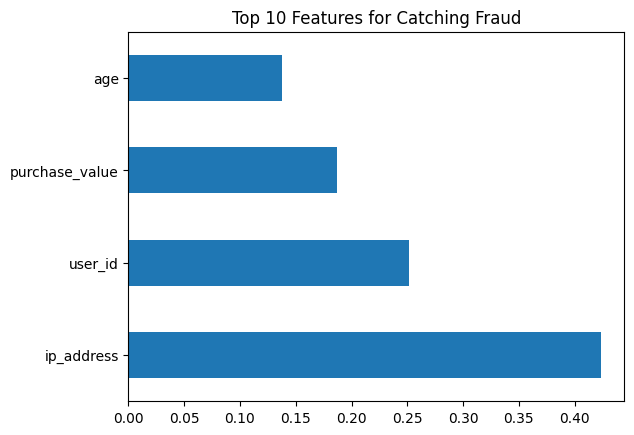

In [7]:
# See what the model thinks is important
import pandas as pd
import matplotlib.pyplot as plt

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Features for Catching Fraud")
plt.show()

In [8]:
from xgboost import XGBClassifier

# Train a second, smarter model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_res, y_train_res)

# Predict and check results
xgb_preds = xgb_model.predict(X_test)
print("--- XGBOOST RESULTS ---")
print(classification_report(y_test, xgb_preds))

--- XGBOOST RESULTS ---
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     27393
           1       0.17      0.60      0.26      2830

    accuracy                           0.68     30223
   macro avg       0.56      0.65      0.53     30223
weighted avg       0.87      0.68      0.75     30223



In [9]:
import pandas as pd
import os

# 1. Load the data (Adjust the path to your 'raw' folder)
raw_data_path = os.path.join('..', 'data', 'raw')
df = pd.read_csv(os.path.join(raw_data_path, 'Fraud_Data.csv'))

# 2. Define X and y (This is what is missing!)
# We keep only numbers and drop the target 'class'
X = df.select_dtypes(include=['number'])
if 'class' in X.columns:
    y = X['class']
    X = X.drop('class', axis=1)
else:
    y = df['class']

print("✅ X and y are now defined!")

✅ X and y are now defined!


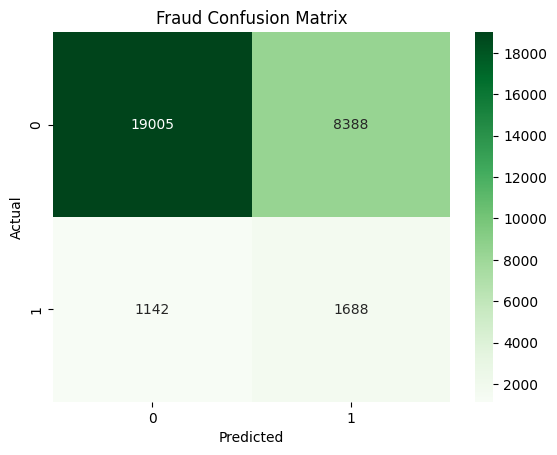

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Fraud Confusion Matrix')
plt.show()